Khai báo thư viện

In [ ]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Đọc dữ liệu

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Big data/sandp500'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Lấy ra mã chứng khoán cần phân tích \\
Ở đây là mã ABC





In [ ]:
stock_data = pd.read_csv('/content/drive/MyDrive/Big data/sandp500/individual_stocks_5yr/individual_stocks_5yr/ABC_data.csv',).fillna(0)
stock_data

,date,open,high,low,close,volume,Name
0,2013-02-08,46.52,46.895,46.4600,46.89,1232802,ABC
1,2013-02-11,46.85,47.000,46.5000,46.76,1115888,ABC
2,2013-02-12,46.70,47.050,46.6000,46.96,1318773,ABC
3,2013-02-13,46.74,46.900,46.6000,46.64,2645247,ABC
4,2013-02-14,46.67,46.990,46.6000,46.77,1941879,ABC
...,...,...,...,...,...,...,...
1254,2018-02-01,97.74,99.810,95.7300,99.29,2786798,ABC
1255,2018-02-02,99.09,99.090,95.9100,96.02,1660267,ABC
1256,2018-02-05,95.62,96.520,91.6900,91.90,2278534,ABC
1257,2018-02-06,92.58,93.370,86.9403,91.54,4574997,ABC


Trực quan hóa dữ liệu

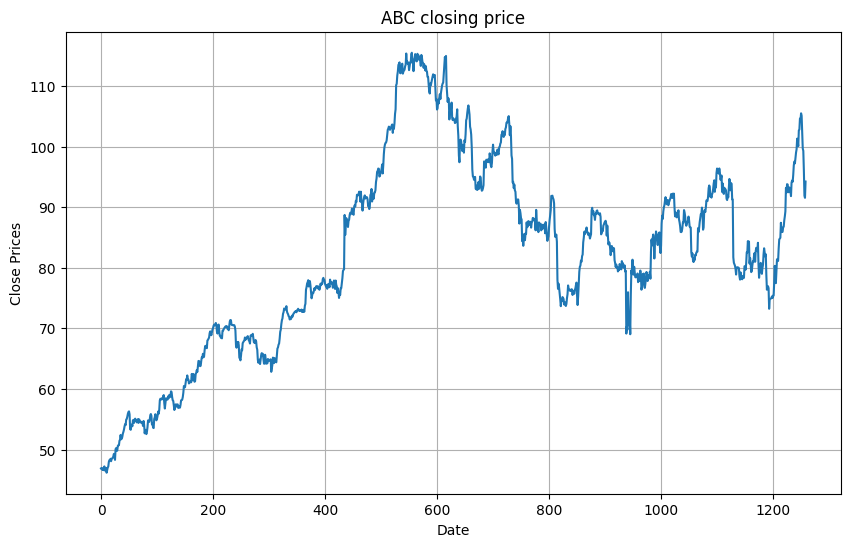

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title('ABC closing price')
plt.show()

<Axes: ylabel='Density'>

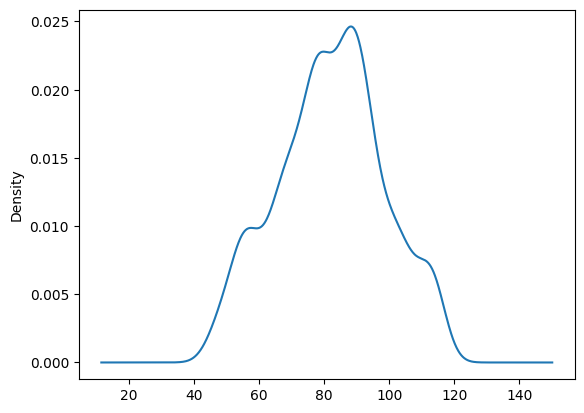

In [ ]:
#Distribution of the dataset
df_close = stock_data['close']
df_close.plot(kind='kde')

Kiểm tra tính dừng của dữ liệu

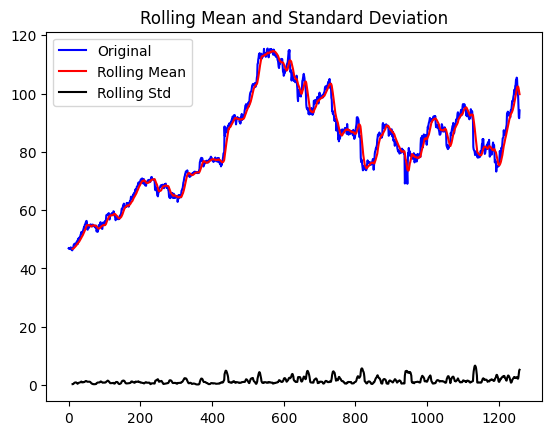

Results of dickey fuller test
Test Statistics                  -2.115931
p-value                           0.238157
No. of lags used                  9.000000
Number of observations used    1249.000000
critical value (1%)              -3.435596
critical value (5%)              -2.863857
critical value (10%)             -2.568004
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

Tách tính xu hướng và tính mùa vụ ra khỏi dữ liệu

<Figure size 640x480 with 0 Axes>

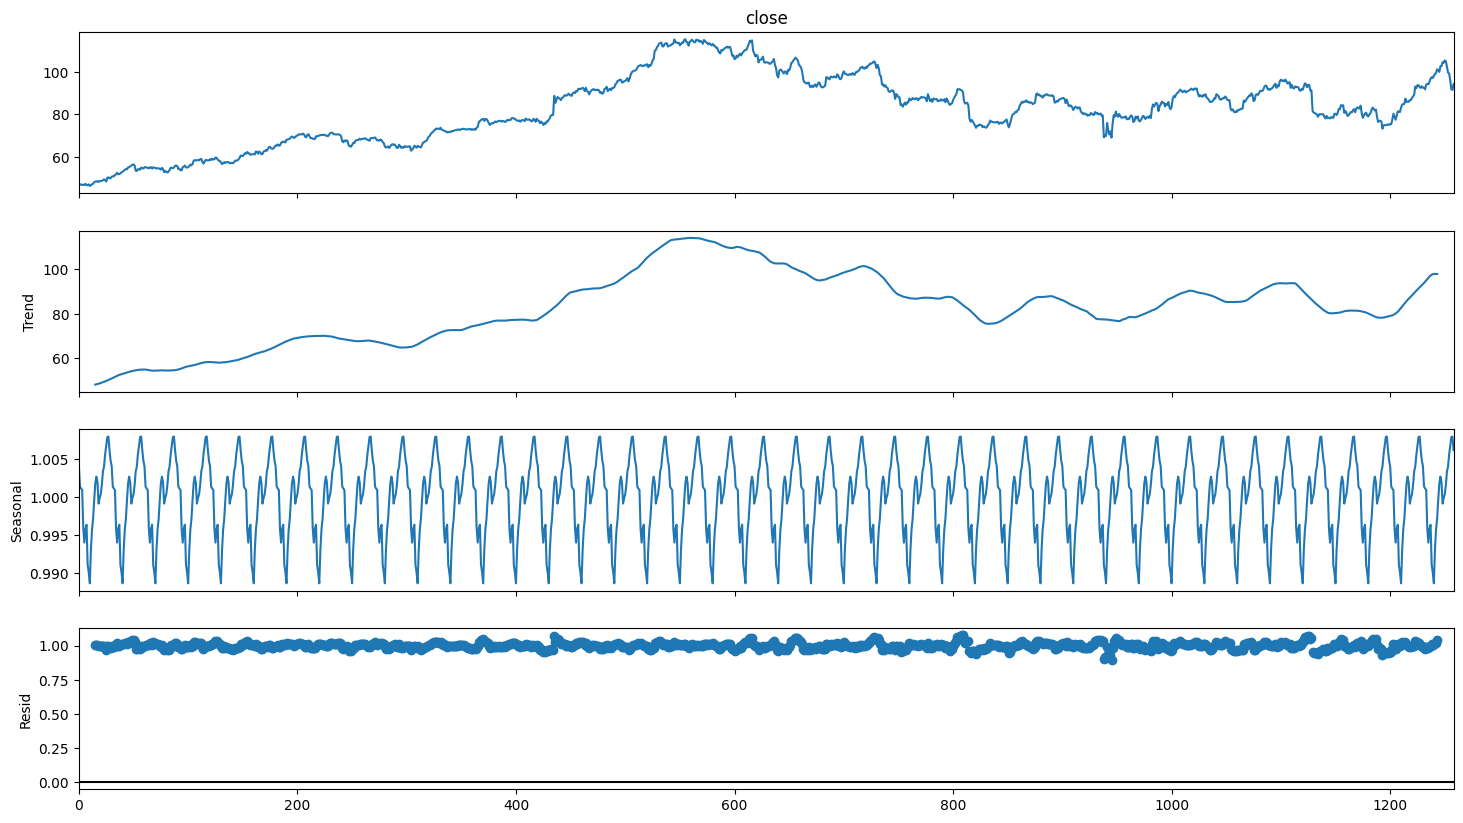

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

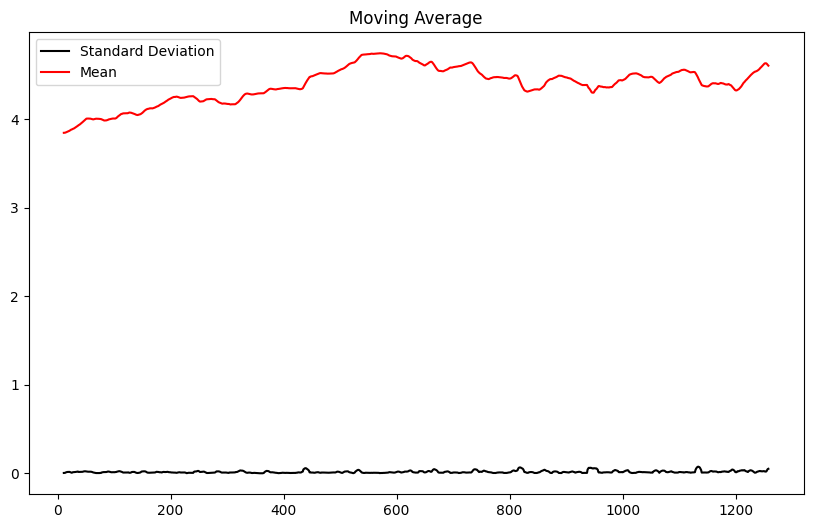

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [ ]:
Chia bộ dữ liệu thành training và testing

In [ ]:
# Extract closing prices for data stock
close_prices = stock_data['close'].values

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(close_prices, train_size=0.8, shuffle=False, random_state=42)

<function matplotlib.pyplot.show(close=None, block=None)>

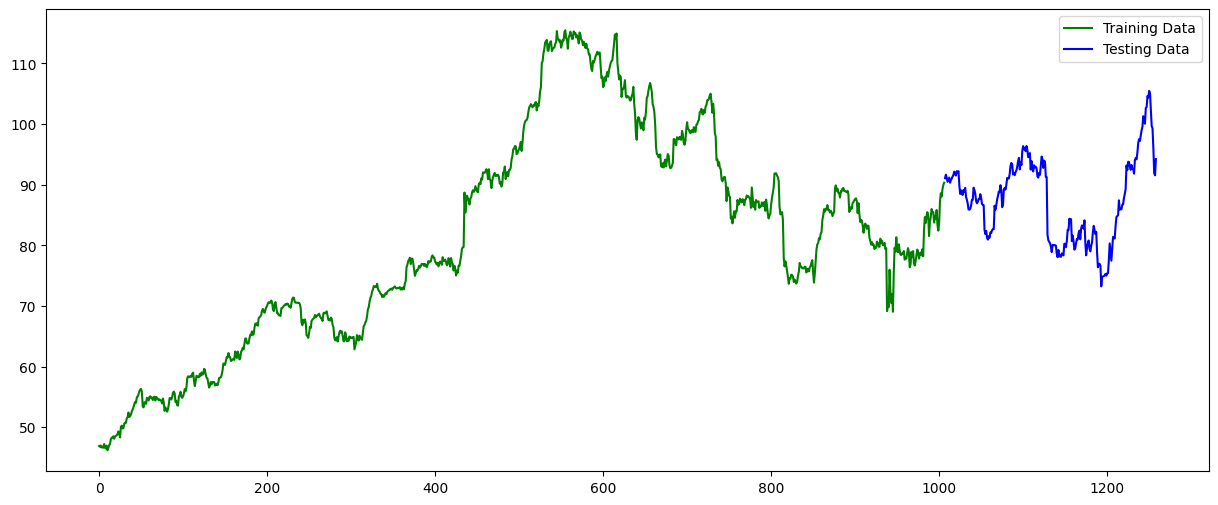

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(train_data, label='Training Data', color="green")

plt.plot(range(len(train_data),(len(test_data)+len(train_data)) ), test_data, label="Testing Data", color="blue")

plt.legend()

plt.show

Tìm hệ số phù hợp nhất cho mô hình ARIMA

In [ ]:
# Define a function to find the best ARIMA parameters
def best_arima_params(train_data, p_values, d_values, q_values):
    best_score, best_params = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()
                    mse = mean_squared_error(train_data, model_fit.fittedvalues)
                    if mse < best_score:
                        best_score, best_params = mse, (p, d, q)
                except:
                    continue
    return best_params

# Define a range of ARIMA parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Find the best parameters for ARIMA model
best_params = best_arima_params(train_data, p_values, d_values, q_values)

In [ ]:
best_params

(1, 0, 1)

Dự báo giá cổ phiếu với các hệ số tìm được

In [ ]:
# Train the ARIMA model with the best parameters
arima_model = ARIMA(train_data, order=(best_params))
arima_model_fit = arima_model.fit()

# Predict the stock prices for the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

In ra kết quả

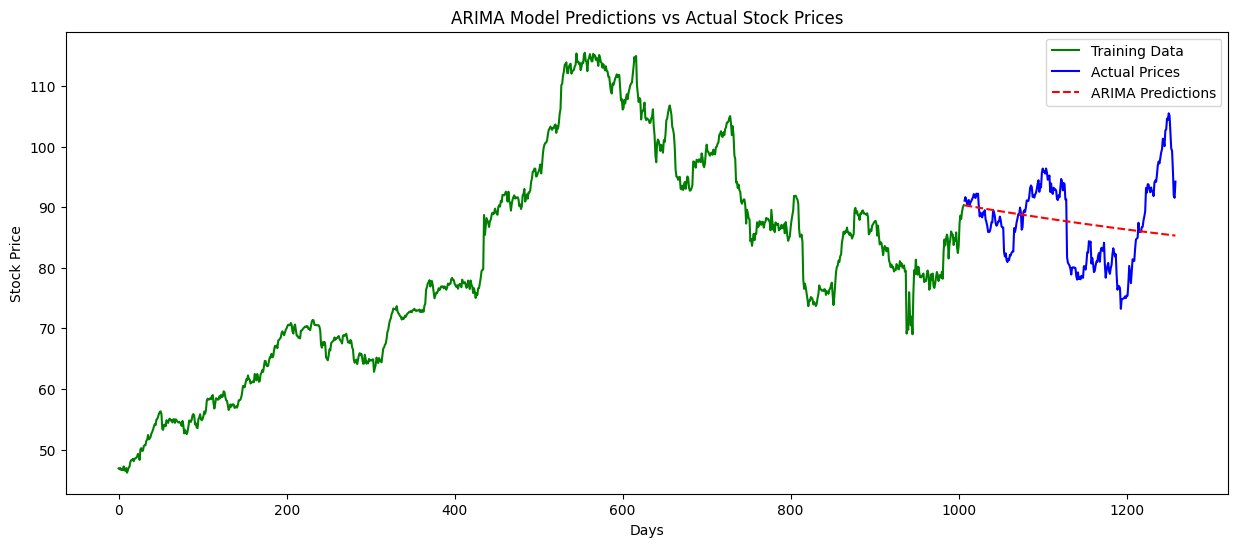

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data', color="green")
plt.plot(range(len(train_data),(len(test_data)+len(train_data)) ),test_data, label="Actual Prices", color="blue")
plt.plot(range(len(train_data),(len(test_data)+len(train_data)) ),arima_predictions, label="ARIMA Predictions", color="red", linestyle="--")
plt.title("ARIMA Model Predictions vs Actual Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.show()